In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

import os, glob

BASE = "/content/drive/MyDrive/Deep_Fake_Detection/CelebDFv2_Extracted/faces"
REAL_DIR = os.path.join(BASE, "real")
FAKE_DIR = os.path.join(BASE, "fake")

print("Real dir:", REAL_DIR)
print("Fake dir:", FAKE_DIR)
print("Real dir exists?", os.path.exists(REAL_DIR))
print("Fake dir exists?", os.path.exists(FAKE_DIR))

real_files = glob.glob(os.path.join(REAL_DIR, "*.jpg"))
fake_files = glob.glob(os.path.join(FAKE_DIR, "*.jpg"))

print("Found real faces:", len(real_files))
print("Found fake faces:", len(fake_files))

print("Sample real:", real_files[:5])
print("Sample fake:", fake_files[:5])


Mounted at /content/drive
Real dir: /content/drive/MyDrive/Deep_Fake_Detection/CelebDFv2_Extracted/faces/real
Fake dir: /content/drive/MyDrive/Deep_Fake_Detection/CelebDFv2_Extracted/faces/fake
Real dir exists? True
Fake dir exists? True
Found real faces: 27412
Found fake faces: 58513
Sample real: ['/content/drive/MyDrive/Deep_Fake_Detection/CelebDFv2_Extracted/faces/real/id7_0009_f000210.jpg', '/content/drive/MyDrive/Deep_Fake_Detection/CelebDFv2_Extracted/faces/real/id7_0009_f000219.jpg', '/content/drive/MyDrive/Deep_Fake_Detection/CelebDFv2_Extracted/faces/real/id7_0009_f000229.jpg', '/content/drive/MyDrive/Deep_Fake_Detection/CelebDFv2_Extracted/faces/real/id7_0009_f000238.jpg', '/content/drive/MyDrive/Deep_Fake_Detection/CelebDFv2_Extracted/faces/real/id7_0009_f000247.jpg']
Sample fake: ['/content/drive/MyDrive/Deep_Fake_Detection/CelebDFv2_Extracted/faces/fake/id21_id9_0005_f000042.jpg', '/content/drive/MyDrive/Deep_Fake_Detection/CelebDFv2_Extracted/faces/fake/id21_id9_0005_f000

In [ ]:
import random, shutil

DATASET_BASE = "/content/drive/MyDrive/Deep_Fake_Detection/dataset"
TRAIN_REAL = os.path.join(DATASET_BASE, "train", "real")
TRAIN_FAKE = os.path.join(DATASET_BASE, "train", "fake")
VAL_REAL   = os.path.join(DATASET_BASE, "val", "real")
VAL_FAKE   = os.path.join(DATASET_BASE, "val", "fake")

for d in [TRAIN_REAL, TRAIN_FAKE, VAL_REAL, VAL_FAKE]:
    os.makedirs(d, exist_ok=True)

N_REAL = 5000
N_FAKE = 5000
VAL_SPLIT = 0.2

random.shuffle(real_files)
random.shuffle(fake_files)

real_files = real_files[:N_REAL]
fake_files = fake_files[:N_FAKE]

n_val_real = int(len(real_files) * VAL_SPLIT)
n_val_fake = int(len(fake_files) * VAL_SPLIT)

val_real_files = real_files[:n_val_real]
train_real_files = real_files[n_val_real:]

val_fake_files = fake_files[:n_val_fake]
train_fake_files = fake_files[n_val_fake:]

def copy_list(files, out_dir):
    for f in files:
        shutil.copy2(f, out_dir)

copy_list(train_real_files, TRAIN_REAL)
copy_list(train_fake_files, TRAIN_FAKE)
copy_list(val_real_files,   VAL_REAL)
copy_list(val_fake_files,   VAL_FAKE)

print("Train real:", len(os.listdir(TRAIN_REAL)))
print("Train fake:", len(os.listdir(TRAIN_FAKE)))
print("Val real:", len(os.listdir(VAL_REAL)))
print("Val fake:", len(os.listdir(VAL_FAKE)))


Train real: 4000
Train fake: 4000
Val real: 1000
Val fake: 1000


In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMG_SIZE = 224
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_directory(
    "/content/drive/MyDrive/Deep_Fake_Detection/dataset/train",
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

val_gen = val_datagen.flow_from_directory(
    "/content/drive/MyDrive/Deep_Fake_Detection/dataset/val",
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary'
)


Found 8000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


In [ ]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model

base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224,224,3))
base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
output = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=output)

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,422,081 (9.24 MB)

 Trainable params: 164,097 (641.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [ ]:
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10
)


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 617s 2s/step - accuracy: 0.7295 - loss: 0.5331 - val_accuracy: 0.7800 - val_loss: 0.4450
Epoch 2/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 583s 2s/step - accuracy: 0.8410 - loss: 0.3714 - val_accuracy: 0.8280 - val_loss: 0.3839
Epoch 3/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 507s 2s/step - accuracy: 0.8718 - loss: 0.3157 - val_accuracy: 0.8455 - val_loss: 0.3484
Epoch 4/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 580s 2s/step - accuracy: 0.8780 - loss: 0.2947 - val_accuracy: 0.8650 - val_loss: 0.3142
Epoch 5/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 558s 2s/step - accuracy: 0.8865 - loss: 0.2709 - val_accuracy: 0.8625 - val_loss: 0.3147
Epoch 6/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 537s 2s/step - accuracy: 0.9097 - loss: 0.2364 - val_accuracy: 0.8885 - val_loss: 0.2723
Epoch 7/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 514s 2s/step - accuracy: 0.9092 - loss: 0.2284 - val_accuracy: 0.8940 - val_loss: 0.2567
Epoch 8/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 511s 2s/step - accuracy: 0.9233 - loss: 0.1911 - val_accu

In [ ]:
import os

MODEL_DIR = "/content/drive/MyDrive/Deep_Fake_Detection/models"
os.makedirs(MODEL_DIR, exist_ok=True)

MODEL_PATH = os.path.join(MODEL_DIR, "celebdf_faces_cnn_v1.h5")
model.save(MODEL_PATH)

print("Model saved at:", MODEL_PATH)

Model saved at: /content/drive/MyDrive/Deep_Fake_Detection/models/celebdf_faces_cnn_v1.h5


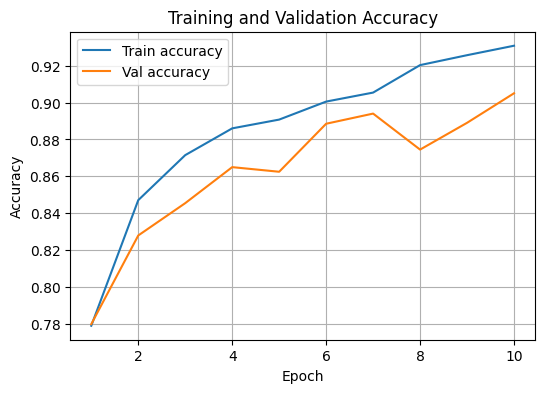

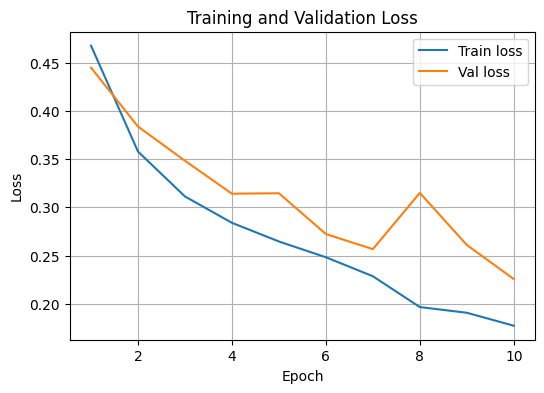

In [ ]:
import matplotlib.pyplot as plt

acc      = history.history["accuracy"]
val_acc  = history.history["val_accuracy"]
loss     = history.history["loss"]
val_loss = history.history["val_loss"]

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(6,4))
plt.plot(epochs, acc, label="Train accuracy")
plt.plot(epochs, val_acc, label="Val accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(6,4))
plt.plot(epochs, loss, label="Train loss")
plt.plot(epochs, val_loss, label="Val loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
print("Final train accuracy :", acc[-1])
print("Final val accuracy   :", val_acc[-1])
print("Final train loss     :", loss[-1])
print("Final val loss       :", val_loss[-1])

Final train accuracy : 0.9307500123977661
Final val accuracy   : 0.9049999713897705
Final train loss     : 0.17715245485305786
Final val loss       : 0.22560425102710724


In [ ]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,750,277 (10.49 MB)

 Trainable params: 164,097 (641.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

 Optimizer params: 328,196 (1.25 MB)

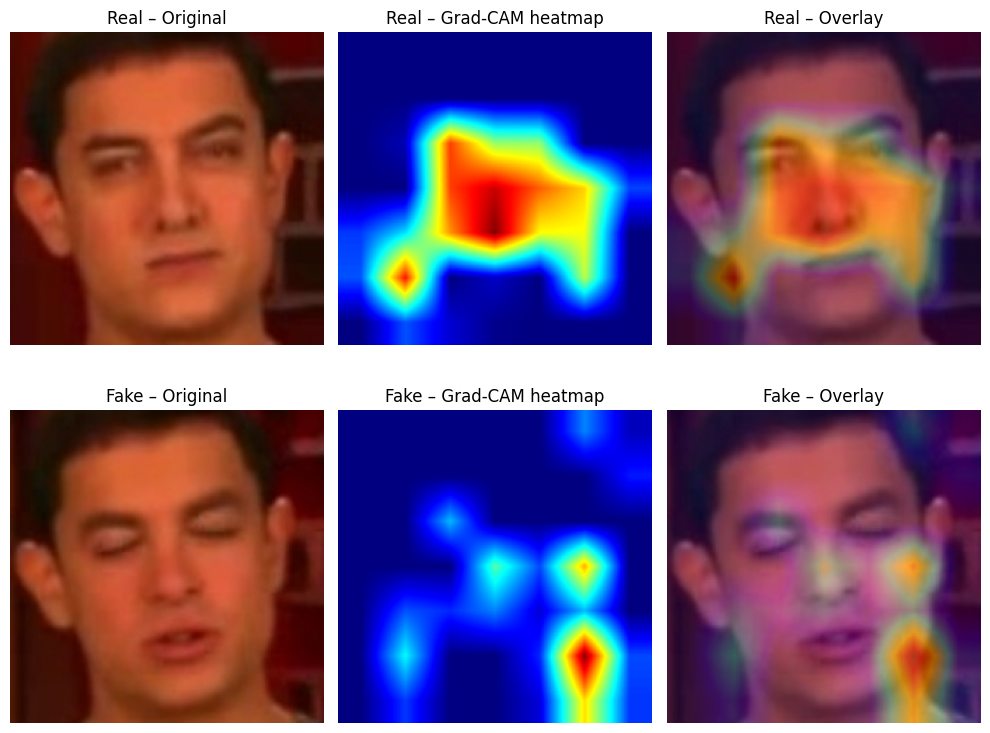

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt
import cv2
import os

real_example = real_example 
fake_example = fake_example  

LAST_CONV_LAYER_NAME = "out_relu"  

def make_gradcam_heatmap(img_array, model, last_conv_layer_name):
    
    grad_model = tf.keras.models.Model(
        [model.inputs],
        [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        loss = predictions[:, 0]          

    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    heatmap = tf.maximum(heatmap, 0) / (tf.reduce_max(heatmap) + 1e-8)
    return heatmap.numpy()

def preprocess_for_model(path):
    img = load_img(path, target_size=(224, 224))
    x = img_to_array(img)
    x = np.expand_dims(x, axis=0) / 255.0
    return img, x

def overlay_heatmap(heatmap, image, alpha=0.4, cmap=cv2.COLORMAP_JET):
    heatmap = cv2.resize(heatmap, (image.size[0], image.size[1]))
    heatmap = np.uint8(255 * heatmap)
    heatmap_color = cv2.applyColorMap(heatmap, cmap)
    heatmap_color = cv2.cvtColor(heatmap_color, cv2.COLOR_BGR2RGB)
    overlay = heatmap_color * alpha + np.array(image)
    overlay = np.clip(overlay / overlay.max(), 0, 1)
    return heatmap_color, overlay


samples = [
    (real_example, "Real"),
    (fake_example, "Fake"),
]

fig, axes = plt.subplots(2, 3, figsize=(10, 8))

for row, (path, label) in enumerate(samples):
    img, x = preprocess_for_model(path)
    heatmap = make_gradcam_heatmap(x, model, LAST_CONV_LAYER_NAME)
    heatmap_color, overlay = overlay_heatmap(heatmap, img)

    # original
    axes[row, 0].imshow(img)
    axes[row, 0].set_title(f"{label} – Original")
    axes[row, 0].axis("off")

    # heatmap
    axes[row, 1].imshow(heatmap_color)
    axes[row, 1].set_title(f"{label} – Grad-CAM heatmap")
    axes[row, 1].axis("off")

    # overlay
    axes[row, 2].imshow(overlay)
    axes[row, 2].set_title(f"{label} – Overlay")
    axes[row, 2].axis("off")

plt.tight_layout()
plt.show()

In [ ]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

val_gen.reset()
y_prob = model.predict(val_gen)
y_pred = (y_prob.ravel() > 0.5).astype(int)


y_true = val_gen.classes 
class_indices = val_gen.class_indices
idx_to_class = {v: k for k, v in class_indices.items()}
print("Class mapping:", idx_to_class)


cm = confusion_matrix(y_true, y_pred)
print("Confusion matrix:\n", cm)


target_names = [idx_to_class[0], idx_to_class[1]]
print("\nClassification report:\n")
print(classification_report(y_true, y_pred, target_names=target_names))

63/63 ━━━━━━━━━━━━━━━━━━━━ 112s 2s/step
Class mapping: {0: 'fake', 1: 'real'}
Confusion matrix:
 [[498 502]
 [510 490]]

Classification report:

              precision    recall  f1-score   support

        fake       0.49      0.50      0.50      1000
        real       0.49      0.49      0.49      1000

    accuracy                           0.49      2000
   macro avg       0.49      0.49      0.49      2000
weighted avg       0.49      0.49      0.49      2000



In [ ]:

VAL_DIR = os.path.join(DATASET_BASE, "val")  

from tensorflow.keras.preprocessing.image import ImageDataGenerator

val_datagen = ImageDataGenerator(rescale=1./255)

val_gen_eval = val_datagen.flow_from_directory(
    VAL_DIR,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    shuffle=False  
)
print("Class indices:", val_gen_eval.class_indices)


Found 2000 images belonging to 2 classes.
Class indices: {'fake': 0, 'real': 1}


In [ ]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
y_prob = model.predict(val_gen_eval)
y_pred = (y_prob.ravel() > 0.5).astype(int)

y_true = val_gen_eval.classes
idx_to_class = {v: k for k, v in val_gen_eval.class_indices.items()}
print("Index to class:", idx_to_class)

cm = confusion_matrix(y_true, y_pred)
print("Confusion matrix:\n", cm)

print("\nClassification report:\n")
print(classification_report(
    y_true,
    y_pred,
    target_names=[idx_to_class[0], idx_to_class[1]]
))


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


63/63 ━━━━━━━━━━━━━━━━━━━━ 99s 2s/step
Index to class: {0: 'fake', 1: 'real'}
Confusion matrix:
 [[909  91]
 [ 99 901]]

Classification report:

              precision    recall  f1-score   support

        fake       0.90      0.91      0.91      1000
        real       0.91      0.90      0.90      1000

    accuracy                           0.91      2000
   macro avg       0.91      0.91      0.90      2000
weighted avg       0.91      0.91      0.90      2000



In [ ]:
import os
import numpy as np

MODEL_DIR = "/content/drive/MyDrive/Deep_Fake_Detection/models"
os.makedirs(MODEL_DIR, exist_ok=True)

MODEL_PATH = os.path.join(MODEL_DIR, "celebdv2_face_cnn_explainable.h5")
model.save(MODEL_PATH)
print("Model saved to:", MODEL_PATH)

CLASS_INDEX_PATH = os.path.join(MODEL_DIR, "class_indices.npy")
np.save(CLASS_INDEX_PATH, val_gen_eval.class_indices)
print("Class indices saved to:", CLASS_INDEX_PATH)


Model saved to: /content/drive/MyDrive/Deep_Fake_Detection/models/celebdv2_face_cnn_explainable.h5
Class indices saved to: /content/drive/MyDrive/Deep_Fake_Detection/models/class_indices.npy


Using model file: /content/drive/MyDrive/Deep_Fake_Detection/models/celebdf_faces_cnn_v1.h5
Using class index file: /content/drive/MyDrive/Deep_Fake_Detection/models/class_indices.npy


Loaded class indices: {'fake': 0, 'real': 1}
Real example: /content/drive/MyDrive/Deep_Fake_Detection/dataset/val/real/id5_0003_f000427.jpg
Fake example: /content/drive/MyDrive/Deep_Fake_Detection/dataset/val/fake/id19_id23_0007_f000026.jpg


/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['input_layer']]
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


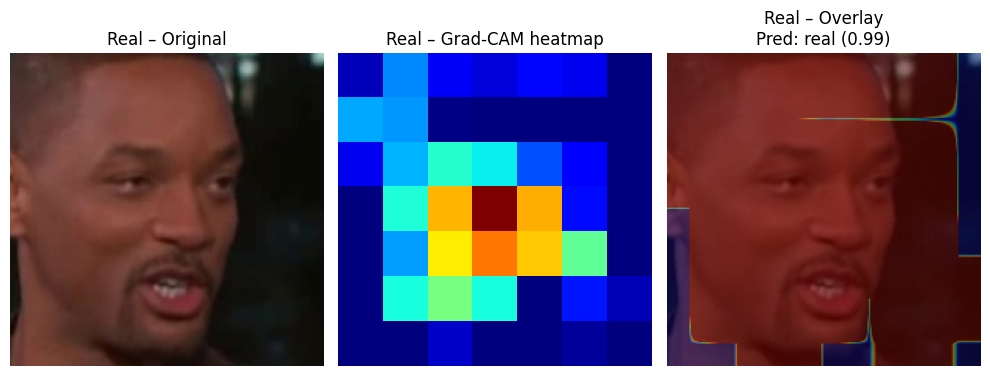

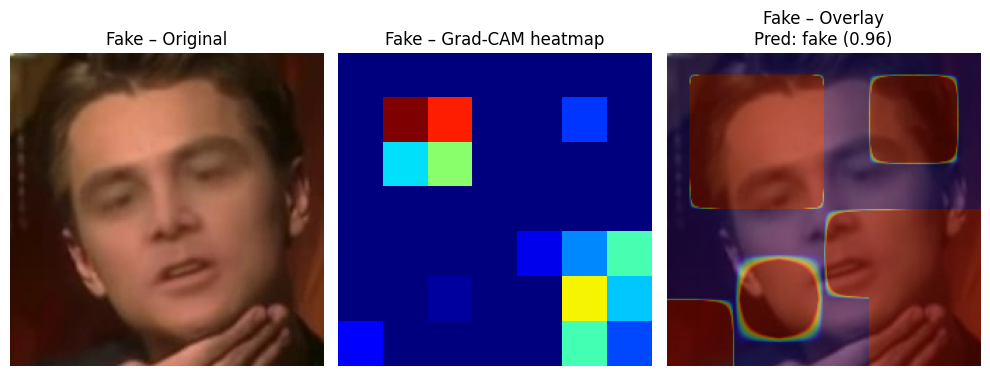

In [ ]:
import os, glob, numpy as np, tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array


MODEL_DIR = "/content/drive/MyDrive/Deep_Fake_Detection/models"


model_candidates = glob.glob(os.path.join(MODEL_DIR, "*.h5"))
if not model_candidates:
    raise FileNotFoundError(f"No .h5 model found in {MODEL_DIR}")
MODEL_PATH = model_candidates[0]


indices_candidates = glob.glob(os.path.join(MODEL_DIR, "*class_indices*.npy"))
if not indices_candidates:
    raise FileNotFoundError(f"No class_indices .npy found in {MODEL_DIR}")
CLASS_INDEX_PATH = indices_candidates[0]

print("Using model file:", MODEL_PATH)
print("Using class index file:", CLASS_INDEX_PATH)

model = load_model(MODEL_PATH)
class_indices = np.load(CLASS_INDEX_PATH, allow_pickle=True).item()
print("Loaded class indices:", class_indices)

IMG_SIZE = 224
LAST_CONV_LAYER = "out_relu"      

VAL_REAL = "/content/drive/MyDrive/Deep_Fake_Detection/dataset/val/real"
VAL_FAKE = "/content/drive/MyDrive/Deep_Fake_Detection/dataset/val/fake"

real_example_path = glob.glob(os.path.join(VAL_REAL, "*.jpg"))[0]
fake_example_path = glob.glob(os.path.join(VAL_FAKE, "*.jpg"))[0]
print("Real example:", real_example_path)
print("Fake example:", fake_example_path)



def make_gradcam_heatmap(img_array, model, last_conv_layer):
    grad_model = tf.keras.models.Model(
        [model.inputs],
        [model.get_layer(last_conv_layer).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        class_idx = tf.argmax(predictions[0])
        loss = predictions[:, class_idx]

    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()


def overlay_heatmap(img_path, heatmap, alpha=0.4):
    img = load_img(img_path, target_size=(IMG_SIZE, IMG_SIZE))
    img = img_to_array(img)

    heatmap = np.uint8(255 * heatmap)
    heatmap = tf.image.resize(heatmap[..., np.newaxis], (IMG_SIZE, IMG_SIZE)).numpy()
    heatmap = plt.cm.jet(heatmap.squeeze())[:, :, :3] * 255

    overlay = img * (1 - alpha) + heatmap * alpha
    return img.astype("uint8"), overlay.astype("uint8")


def predict_and_explain(img_path, label_name):
    img = load_img(img_path, target_size=(IMG_SIZE, IMG_SIZE))
    img_array = img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    prob = model.predict(img_array, verbose=0)[0][0]
    pred_label = "real" if prob >= 0.5 else "fake"
    conf = prob if pred_label == "real" else 1 - prob

    heatmap = make_gradcam_heatmap(img_array, model, LAST_CONV_LAYER)
    original, overlay = overlay_heatmap(img_path, heatmap)

    plt.figure(figsize=(10,4))

    plt.subplot(1,3,1)
    plt.title(f"{label_name} – Original")
    plt.imshow(original)
    plt.axis("off")

    plt.subplot(1,3,2)
    plt.title(f"{label_name} – Grad-CAM heatmap")
    plt.imshow(heatmap, cmap="jet")
    plt.axis("off")

    plt.subplot(1,3,3)
    plt.title(f"{label_name} – Overlay\nPred: {pred_label} ({conf:.2f})")
    plt.imshow(overlay)
    plt.axis("off")

    plt.tight_layout()
    plt.show()


predict_and_explain(real_example_path, "Real")
predict_and_explain(fake_example_path, "Fake")


In [ ]:
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img
import random
import os

real_dir = "/content/drive/MyDrive/Deep_Fake_Detection/dataset/train/real"
fake_dir = "/content/drive/MyDrive/Deep_Fake_Detection/dataset/train/fake"

real_imgs = random.sample(os.listdir(real_dir), 4)
fake_imgs = random.sample(os.listdir(fake_dir), 4)

plt.figure(figsize=(8,6))

for i, img in enumerate(real_imgs + fake_imgs):
    if i < 4:
        path = os.path.join(real_dir, img)
        label = "REAL"
    else:
        path = os.path.join(fake_dir, img)
        label = "FAKE"

    plt.subplot(2,4,i+1)
    plt.imshow(load_img(path))
    plt.title(label)
    plt.axis("off")

plt.suptitle("Dataset Samples (Real vs Fake)")
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/Deep_Fake_Detection/dataset/train/real'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


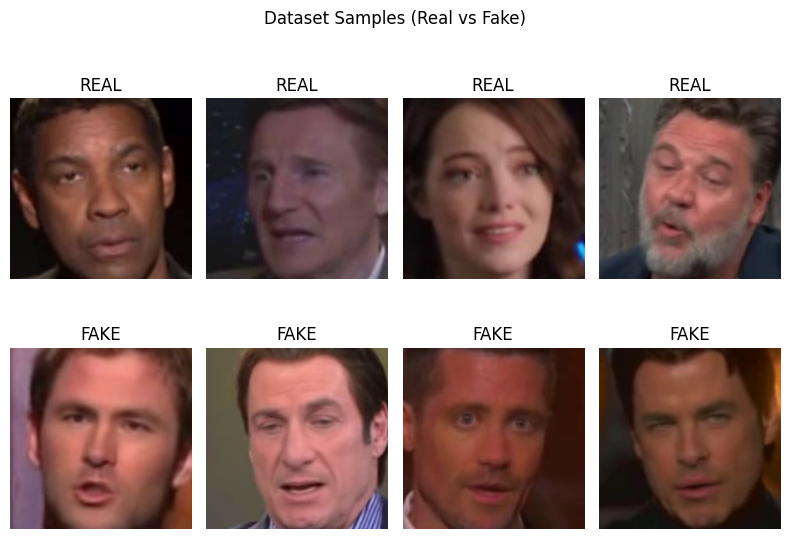

In [ ]:
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img
import random
import os

real_dir = "/content/drive/MyDrive/Deep_Fake_Detection/dataset/train/real"
fake_dir = "/content/drive/MyDrive/Deep_Fake_Detection/dataset/train/fake"

real_imgs = random.sample(os.listdir(real_dir), 4)
fake_imgs = random.sample(os.listdir(fake_dir), 4)

plt.figure(figsize=(8,6))

for i, img in enumerate(real_imgs + fake_imgs):
    if i < 4:
        path = os.path.join(real_dir, img)
        label = "REAL"
    else:
        path = os.path.join(fake_dir, img)
        label = "FAKE"

    plt.subplot(2,4,i+1)
    plt.imshow(load_img(path))
    plt.title(label)
    plt.axis("off")

plt.suptitle("Dataset Samples (Real vs Fake)")
plt.tight_layout()
plt.show()

Found model files: ['/content/drive/MyDrive/Deep_Fake_Detection/models/celebdf_faces_cnn_v1.h5', '/content/drive/MyDrive/Deep_Fake_Detection/models/celebdv2_face_cnn_explainable.h5']
Using model: /content/drive/MyDrive/Deep_Fake_Detection/models/celebdf_faces_cnn_v1.h5


Model loaded successfully.
Found 2000 images belonging to 2 classes.


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


63/63 ━━━━━━━━━━━━━━━━━━━━ 294s 5s/step
ROC AUC: 0.9688789999999999


/tmp/ipython-input-518329039.py:59: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "k--" (-> linestyle='--'). The keyword argument will take precedence.
  plt.plot([0,1], [0,1], 'k--', linestyle='--', label="Chance")


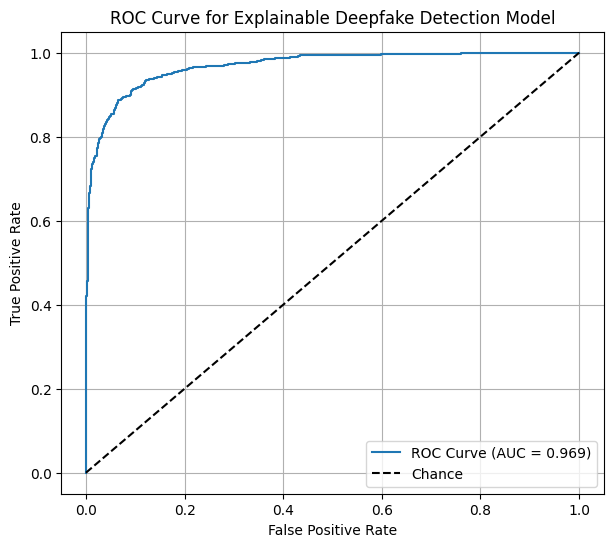

In [ ]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np
import os, glob


MODEL_DIR = "/content/drive/MyDrive/Deep_Fake_Detection/models"

model_files = glob.glob(os.path.join(MODEL_DIR, "*.h5"))
print("Found model files:", model_files)

if len(model_files) == 0:
    raise FileNotFoundError("No .h5 model found in models folder. Check Drive > Deep_Fake_Detection > models")

MODEL_PATH = model_files[0]
print("Using model:", MODEL_PATH)

model = load_model(MODEL_PATH)
print("Model loaded successfully.")

VAL_DIR = "/content/drive/MyDrive/Deep_Fake_Detection/dataset/val"

val_datagen = ImageDataGenerator(rescale=1./255)

val_gen = val_datagen.flow_from_directory(
    VAL_DIR,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)

y_true = val_gen.classes
y_probs = model.predict(val_gen).ravel()


fpr, tpr, thresholds = roc_curve(y_true, y_probs)
roc_auc = auc(fpr, tpr)
print("ROC AUC:", roc_auc)


plt.figure(figsize=(7,6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.3f})")
plt.plot([0,1], [0,1], 'k--', linestyle='--', label="Chance")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for Explainable Deepfake Detection Model")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


In [ ]:
!pip install pydot graphviz

import tensorflow as tf
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import load_model
import os

ERROR: Operation cancelled by user


63/63 ━━━━━━━━━━━━━━━━━━━━ 87s 1s/step
Confusion matrix:
 [[909  91]
 [ 99 901]]


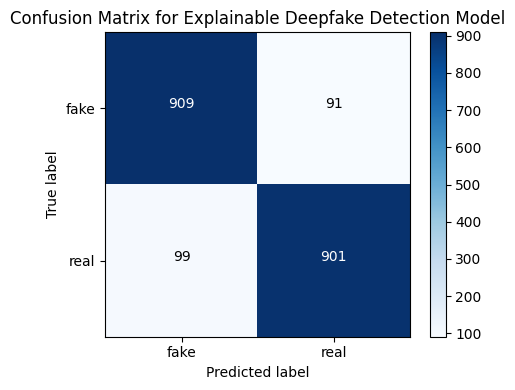


Classification report:

              precision    recall  f1-score   support

        fake       0.90      0.91      0.91      1000
        real       0.91      0.90      0.90      1000

    accuracy                           0.91      2000
   macro avg       0.91      0.91      0.90      2000
weighted avg       0.91      0.91      0.90      2000



In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import numpy as np

y_true = val_gen.classes
y_probs = model.predict(val_gen).ravel()
y_pred  = (y_probs >= 0.5).astype(int)  


cm = confusion_matrix(y_true, y_pred)
print("Confusion matrix:\n", cm)


classes = ['fake', 'real']

plt.figure(figsize=(5,4))
plt.imshow(cm, interpolation='nearest', cmap='Blues')
plt.title("Confusion Matrix for Explainable Deepfake Detection Model")
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)

plt.xlabel('Predicted label')
plt.ylabel('True label')

thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.show()

print("\nClassification report:\n")
print(classification_report(y_true, y_pred, target_names=classes))


In [ ]:
plt.savefig("roc_curve.png", dpi=300, bbox_inches="tight")

<Figure size 640x480 with 0 Axes>

In [ ]:
!pip install pydot graphviz

import tensorflow as tf
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import load_model
import os

In [ ]:
import os
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import plot_model

MODELS_DIR = "/content/drive/MyDrive/Deep_Fake_Detection/models"

print("Available model files:")
model_files = [f for f in os.listdir(MODELS_DIR) if f.endswith(".h5")]
for f in model_files:
    print(" -", f)


MODEL_PATH = os.path.join(MODELS_DIR, "celebvd2_face_cnn_explainable.h5")

print("\nUsing model:", MODEL_PATH)

model = load_model(MODEL_PATH)
print("✅ Model loaded successfully")


ARCH_PATH = os.path.join(MODELS_DIR, "cnn_architecture_diagram.png")

plot_model(
    model,
    to_file=ARCH_PATH,
    show_shapes=True,
    show_layer_names=True,
    dpi=120
)

print("\n✅ CNN Architecture diagram saved at:")
print(ARCH_PATH)


Available model files:
 - celebdf_faces_cnn_v1.h5
 - celebdv2_face_cnn_explainable.h5

Using model: /content/drive/MyDrive/Deep_Fake_Detection/models/celebvd2_face_cnn_explainable.h5


FileNotFoundError: [Errno 2] Unable to synchronously open file (unable to open file: name = '/content/drive/MyDrive/Deep_Fake_Detection/models/celebvd2_face_cnn_explainable.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [ ]:
from tensorflow.keras.utils import plot_model
import os

ARCH_PATH = "/content/drive/MyDrive/Deep_Fake_Detection/models/cnn_architecture_diagram.png"

os.makedirs(os.path.dirname(ARCH_PATH), exist_ok=True)

plot_model(
    model,
    to_file=ARCH_PATH,
    show_shapes=True,
    show_layer_names=True,
    dpi=120
)

print("✅ CNN architecture diagram saved at:")
print(ARCH_PATH)


✅ CNN architecture diagram saved at:
/content/drive/MyDrive/Deep_Fake_Detection/models/cnn_architecture_diagram.png


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import os

print("Contents of MyDrive:\n")
print(os.listdir("/content/drive/MyDrive"))


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Contents of MyDrive:

['dataSET', 'Frames', 'Frames_Original', 'Frames_Manipulated', 'Dolon_Das_Data_Analyst_Resume_Clean.pdf', 'DeepFake_Detection_Phase1_Presentation.pptx', 'DolonDas_28_graph theory assignment .pdf', 'class 10 th result .pdf', 'class 12 th result .pdf', 'graduation 1 st semester .pdf', 'graduation second semester .pdf', 'graduation third semester .pdf', 'graduation fourth semester .pdf', 'graduation fifth semester .pdf', 'graduation sixth semester .pdf', "master's first semester .pdf", "master's second semester .pdf", 'Space and Time Complexity (1).pptx', 'Space and Time Complexity.pptx', 'Colab Notebooks']


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import os

PROJECT_ROOT = "/content/drive/MyDrive/Deep_Fake_Detection"
MODELS_DIR   = os.path.join(PROJECT_ROOT, "models")

print("Models dir:", MODELS_DIR)
print("\nFiles in models/:")
print(os.listdir(MODELS_DIR))


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Models dir: /content/drive/MyDrive/Deep_Fake_Detection/models

Files in models/:
['celebdf_faces_cnn_v1.h5', 'celebdv2_face_cnn_explainable.h5', 'class_indices.npy', 'cnn_architecture_diagram.png']


In [ ]:
from tensorflow.keras.models import load_model
import os

PROJECT_ROOT = "/content/drive/MyDrive/Deep_Fake_Detection"
MODELS_DIR   = os.path.join(PROJECT_ROOT, "models")

MODEL_NAME = "celebdv2_face_cnn_explainable.h5"
MODEL_PATH = os.path.join(MODELS_DIR, MODEL_NAME)

assert os.path.exists(MODEL_PATH), f"Model file not found: {MODEL_PATH}"
model = load_model(MODEL_PATH)
print("Model loaded from:", MODEL_PATH)

Model loaded from: /content/drive/MyDrive/Deep_Fake_Detection/models/celebdv2_face_cnn_explainable.h5
